In [4]:
import os
import movingpandas as mpd
mpd.show_versions()
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import movingpandas as mpd
import matplotlib.pyplot as plt
from IPython.display import display
from datetime import timedelta
from holoviews import opts

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=500, frame_height=400))


MovingPandas 0.16.0

SYSTEM INFO
-----------
python     : 3.9.16 (main, May 15 2023, 23:46:34)  [GCC 11.2.0]
executable : /home/dmp/anaconda3/envs/ARPA-FCA_venv/bin/python
machine    : Linux-5.10.16.3-microsoft-standard-WSL2-x86_64-with-glibc2.31

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.7.0
GDAL data dir: /home/dmp/anaconda3/envs/ARPA-FCA_venv/lib/python3.9/site-packages/fiona/gdal_data
PROJ       : 9.2.1
PROJ data dir: /home/dmp/anaconda3/envs/ARPA-FCA_venv/lib/python3.9/site-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.13.2
pandas     : 1.5.3
fiona      : 1.9.4
numpy      : 1.24.3
shapely    : 2.0.1
rtree      : 1.0.1
pyproj     : 3.6.0
matplotlib : 3.7.1
mapclassify: 2.5.0
geopy      : 2.3.0
holoviews  : 1.16.2
hvplot     : 0.8.2
geoviews   : 1.10.0
stonesoup  : None


Load Data

In [5]:
def load_data(filepath, filename):
    file = filepath + filename
    data = pd.read_csv(file)
    return data


cwd = os.getcwd()
data_path = cwd + '/Data/'
file_name_1 = 'cyrene_logistics_incremental 22-03-2023.csv'
file_name_2 = 'cyrene_logistics_incremental 05-05-2023.csv'
file_name_3 = 'Logistics_edge_nodes 20-06-2022.csv'

df_new_1 = load_data(data_path, file_name_1)
df_new_1['file_source'] = 'new_2023'
df_new_2 = load_data(data_path, file_name_2)
df_new_2['file_source'] = 'new_2023'

df_old = pd.read_csv(data_path + file_name_3, index_col = 0, dtype={'GPS_lat' : float, 'GPS_long': float})
df_old['batt_level'] = None
df_old['file_source'] = 'old_2022'

df_new = pd.concat([df_new_1,df_new_2])
print('data is loaded')

#########################
df = df_new.copy()
#########################
# df = df_old
#########################

# df['timestamp'] = pd.to_datetime(df['timestamp'])
# df['date'] = pd.to_datetime(df['timestamp']).dt.date
# df['time'] = pd.to_datetime(df['timestamp']).dt.time

data is loaded


Concatenete new (2023) and old (2022) data in one single df

In [6]:
new_columns_list = [col for col in df.columns if col in df_old.columns]
print(new_columns_list)
df_new = df_new[new_columns_list]
print('df_new is a', df_new.shape, ' dataset')
df_old = df_old[new_columns_list]
print('df_old is a', df_old.shape, ' dataset')

# before concatenating, df_new node_sn numbers are shifted
# in order to have unique node_sn values across the entire new df dataset
df_new['node_sn'] = df_new['node_sn'] + 17

print('11441 + 8488 =', 11441 + 8488)
df = pd.concat([df_new,df_old])
print('df is a', df.shape, ' dataset')

# shift column 'file_source' to first position
first_column = df.pop('file_source')
df.insert(0, 'file_source', first_column)

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = pd.to_datetime(df['timestamp']).dt.date
df['time'] = pd.to_datetime(df['timestamp']).dt.time

['node_sn', 'timestamp', 'GPS_lat', 'GPS_lon', 'GPS_alt', 'GPS_speed', 'GPS_num_sats', 'temperature', 'batt_level', 'file_source']
df_new is a (8488, 10)  dataset
df_old is a (11441, 10)  dataset
11441 + 8488 = 19929
df is a (19929, 10)  dataset


In [7]:
print(list(df_new.node_sn.unique()))

[25, 24, 27, 26]


In [8]:
class bbox:
    def __init__(self, location_name, north, west, south, east):
        self.location_name = location_name
        self.north = north
        self.west = west
        self.south = south
        self.east = east

    def is_in_bbox(self, lat, long):
        if ((lat > self.south) and (lat < self.north) and (long > self.west) and (long < self.east)):
                return True
        else:
            return False

In [9]:
def check_in_bbox_list(bbox_list, location_tuple):
    location = 'Break-Location'
    for bbox in bbox_list:
        if bbox.is_in_bbox(location_tuple[0], location_tuple[1]) == True:
            location = bbox.location_name
    return location

Clean data from 0 values in GPS lat & long

In [10]:
# Clean data
print(df.shape[0])
df = df[(df.GPS_lat != 0) & (df.GPS_lon != 0)]
df = df.dropna(axis=1, how='all')
print(df.shape[0])

19929
10375


In [11]:
df.columns

Index(['file_source', 'node_sn', 'timestamp', 'GPS_lat', 'GPS_lon', 'GPS_alt',
       'GPS_speed', 'GPS_num_sats', 'temperature', 'batt_level', 'date',
       'time'],
      dtype='object')

In [12]:
df.sort_values(['node_sn', 'timestamp'], ascending=[True, True], inplace=True)
df = df.reset_index()
df.head()

,index,file_source,node_sn,timestamp,GPS_lat,GPS_lon,GPS_alt,GPS_speed,GPS_num_sats,temperature,batt_level,date,time
0,546,old_2022,1,2022-03-28 17:12:50,45.013988,7.56788,275,0.0,4,25.8305,None,2022-03-28,17:12:50
1,547,old_2022,1,2022-03-28 17:25:50,45.013870,7.56798,289,0.0,4,26.1349,None,2022-03-28,17:25:50
2,551,old_2022,1,2022-03-28 19:23:23,45.012569,7.56539,111,0.0,3,21.1734,None,2022-03-28,19:23:23
3,862,old_2022,1,2022-04-01 09:08:12,45.046070,7.64608,126,0.0,4,22.0813,None,2022-04-01,09:08:12
4,872,old_2022,1,2022-04-01 10:04:18,45.044682,7.64688,284,0.0,5,22.3217,None,2022-04-01,10:04:18


In [13]:
df = df[df['node_sn'] != 23] ## empyt values for node_sn = 23
trucks_ids = list(df.node_sn.unique())
trucks_ids.sort()
print('All different truck IDs are: ' + str(trucks_ids))

All different truck IDs are: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 22, 24, 25, 26, 27]


Number of main trajectories should be equal to truck IDs

In [14]:
traj_collection = mpd.TrajectoryCollection(df, 'node_sn', t='timestamp', x='GPS_lon', y='GPS_lat')
print(traj_collection)

TrajectoryCollection with 23 trajectories


node_sn == 22 is weird and is indeed removed

In [15]:
hvplot_defaults = {'tiles':'OSM', 'frame_height':550, 'frame_width':550, 'line_width':7.0}
traj_collection.get_trajectory(22).hvplot(**hvplot_defaults)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (triangle_angle)

In [16]:
df = df[df['node_sn'] != 22] ## weird values for node_sn = 22
trucks_ids = list(df.node_sn.unique())
trucks_ids.sort()
print('All different truck IDs are: ' + str(trucks_ids))
traj_collection = mpd.TrajectoryCollection(df, 'node_sn', t='timestamp', x='GPS_lon', y='GPS_lat')
print(traj_collection)

All different truck IDs are: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 24, 25, 26, 27]
TrajectoryCollection with 22 trajectories


In [17]:
hvplot_defaults = {'tiles':'OSM', 'frame_height':550, 'frame_width':550, 'line_width':7.0}
traj_collection.get_trajectory(5).hvplot(**hvplot_defaults)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (triangle_angle)

In [18]:
df[df.node_sn == 5]

,index,file_source,node_sn,timestamp,GPS_lat,GPS_lon,GPS_alt,GPS_speed,GPS_num_sats,temperature,batt_level,date,time
1144,698,old_2022,5,2022-03-31 16:59:56,44.993610,7.60002,-29,26.8,3,16.5457,None,2022-03-31,16:59:56
1145,709,old_2022,5,2022-03-31 17:58:52,45.029160,7.63054,-40,0.0,2,17.1839,None,2022-03-31,17:58:52
1146,721,old_2022,5,2022-03-31 19:01:18,45.027611,7.63366,-17,0.0,4,17.2614,None,2022-03-31,19:01:18
1147,757,old_2022,5,2022-03-31 23:01:34,45.029442,7.63228,319,0.0,5,19.8009,None,2022-03-31,23:01:34
1148,767,old_2022,5,2022-04-01 00:01:00,45.029129,7.63227,238,3.4,5,19.5018,None,2022-04-01,00:01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249,10054,old_2022,5,2022-06-08 17:42:46,44.990520,7.51818,289,0.0,4,34.9550,None,2022-06-08,17:42:46
1250,10061,old_2022,5,2022-06-08 18:41:40,44.990601,7.51830,270,0.0,5,34.9630,None,2022-06-08,18:41:40
1251,10068,old_2022,5,2022-06-08 19:41:16,44.990452,7.51797,303,0.0,4,35.3155,None,2022-06-08,19:41:16
1252,10194,old_2022,5,2022-06-09 16:54:15,44.990700,7.51789,285,0.0,4,42.0073,None,2022-06-09,16:54:15


In [19]:
rows_todrop_indexs = df[(df.node_sn == 5) & (df.timestamp > '2022-06-03')].index
df.drop(index=rows_todrop_indexs, inplace = True)

Update traj_collection accordingly

In [20]:
traj_collection = mpd.TrajectoryCollection(df, 'node_sn', t='timestamp', x='GPS_lon', y='GPS_lat')

In [19]:
# traj_collection.plot(column='node_sn', legend=True, figsize=(22,12))
hvplot_defaults = {'tiles':'OSM', 'frame_height':550, 'frame_width':550, 'line_width':7.0}
traj_collection.hvplot(**hvplot_defaults)

:Overlay
   .Tiles.I      :Tiles   [x,y]
   .Path.I       :Path   [Longitude,Latitude]
   .Points.I     :Points   [Longitude,Latitude]   (triangle_angle)
   .Path.II      :Path   [Longitude,Latitude]
   .Points.II    :Points   [Longitude,Latitude]   (triangle_angle,triangle_angle)
   .Path.III     :Path   [Longitude,Latitude]
   .Points.III   :Points   [Longitude,Latitude]   (triangle_angle,triangle_angle,triangle_angle)
   .Path.IV      :Path   [Longitude,Latitude]
   .Points.IV    :Points   [Longitude,Latitude]   (triangle_angle,triangle_angle,triangle_angle,triangle_angle)
   .Path.V       :Path   [Longitude,Latitude]
   .Points.V     :Points   [Longitude,Latitude]   (triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle)
   .Path.VI      :Path   [Longitude,Latitude]
   .Points.VI    :Points   [Longitude,Latitude]   (triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle)
   .Path.VII     :Path   [Longitude,Latitude]
   .Points.VII   :Points   [Longitude,Latitude]   (triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle)
   .Path.VIII    :Path   [Longitude,Latitude]
   .Points.VIII  :Points   [Longitude,Latitude]   (triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle)
   .Path.IX      :Path   [Longitude,Latitude]
   .Points.IX    :Points   [Longitude,Latitude]   (triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle)
   .Path.X       :Path   [Longitude,Latitude]
   .Points.X     :Points   [Longitude,Latitude]   (triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle)
   .Path.XI      :Path   [Longitude,Latitude]
   .Points.XI    :Points   [Longitude,Latitude]   (triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle)
   .Path.XII     :Path   [Longitude,Latitude]
   .Points.XII   :Points   [Longitude,Latitude]   (triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle)
   .Path.XIII    :Path   [Longitude,Latitude]
   .Points.XIII  :Points   [Longitude,Latitude]   (triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle)
   .Path.XIV     :Path   [Longitude,Latitude]
   .Points.XIV   :Points   [Longitude,Latitude]   (triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle)
   .Path.XV      :Path   [Longitude,Latitude]
   .Points.XV    :Points   [Longitude,Latitude]   (triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle)
   .Path.XVI     :Path   [Longitude,Latitude]
   .Points.XVI   :Points   [Longitude,Latitude]   (triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle)
   .Path.XVII    :Path   [Longitude,Latitude]
   .Points.XVII  :Points   [Longitude,Latitude]   (triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle,triangle_angle

Create bbox of main locations

In [21]:
bbox_Gerbole = bbox('Gerbole', 45.00608379933475, 7.494028665630488, 44.9789664976549, 7.541781329617419)
bbox_Samsung = bbox('Samsung', 47.45, 19.12, 47.40, 19.19)
bbox_Mirafiori = bbox('Mirafiori',45.03783123341941, 7.61185459392937,   45.01659162577987, 7.637021253139538)

bbox_Gerbole = bbox('Gerbole', 45.006, 7.48, 44.97, 7.55)
bbox_Samsung = bbox('Samsung', 47.80, 19.0, 47.10, 19.30)
bbox_Mirafiori = bbox('Mirafiori',45.04, 7.61, 45.01, 7.64)

main_bbox_list = [bbox_Gerbole, bbox_Samsung, bbox_Mirafiori]

Consider a specifc truck ID - trajectory from the collection

In [22]:
# for truck_id in trucks_ids:
truck_id = 24
print('truck ID considered is '+ str(truck_id))
my_traj = traj_collection.get_trajectory(truck_id)
print('route sampling interval is ' + str(my_traj.get_sampling_interval()))

truck ID considered is 24
route sampling interval is 0 days 00:17:16


splitting truck ID 24 data produces 10 main trajectories: 

trajectory 0 began on 2023-02-17 09:20:17 from Gerbole travelling 9.98 km in 1:20:31 hours, ended on 2023-02-17 10:40:48 at Mirafiori
trajectory 1 began on 2023-02-21 15:54:54 from Mirafiori travelling 220.63 km in 4:24:28 hours, ended on 2023-02-21 20:19:22 at Break-Location
trajectory 2 began on 2023-02-22 03:48:49 from Break-Location travelling 645.54 km in 11:57:43 hours, ended on 2023-02-22 15:46:32 at Break-Location
trajectory 3 began on 2023-02-23 03:18:19 from Break-Location travelling 232.21 km in 5 days, 9:36:24 hours, ended on 2023-02-28 12:54:43 at Samsung
trajectory 4 began on 2023-03-01 08:46:19 from Samsung travelling 595.25 km in 9:11:32 hours, ended on 2023-03-01 17:57:51 at Break-Location
trajectory 5 began on 2023-03-02 03:18:12 from Break-Location travelling 421.2 km in 6:46:24 hours, ended on 2023-03-02 10:04:36 at Gerbole
trajectory 6 began on 2023-03-31 07:37:49 from Gerbole travelling 9.93 km in 9:31:26

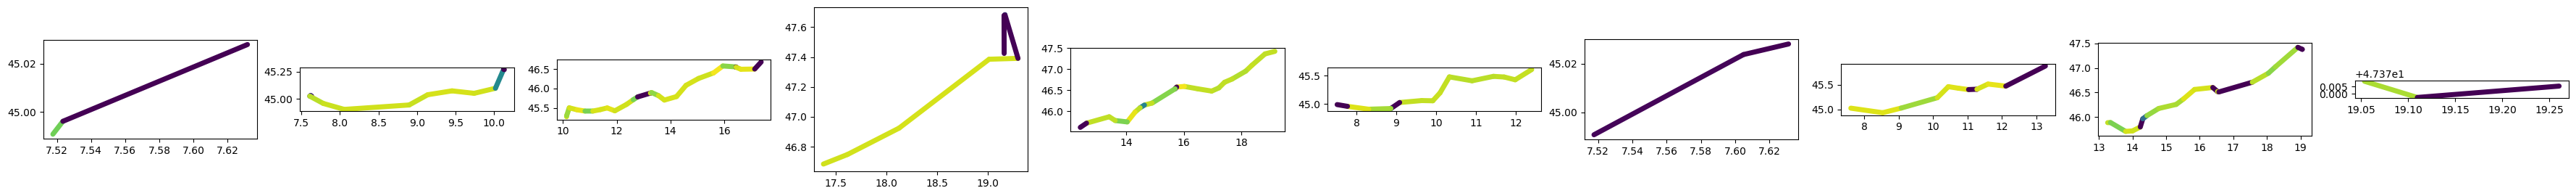

In [23]:
# Split the trajectory where observations stay within max_diameter meters for at least timedelta minutes.
# Discard created trajectories that are shorter than min_length meters long # unit measures are in meters
truck_subcollection_stopsplit = mpd.StopSplitter(my_traj).split(max_diameter=500, min_duration=timedelta(hours=1), min_length=5000) #5km
print('splitting truck ID ' + str(truck_id) + ' data produces ' + str(len(truck_subcollection_stopsplit)) + ' main trajectories: \n')

for i, traj in enumerate(truck_subcollection_stopsplit):
    start_location_latlong = (traj.get_start_location().y, traj.get_start_location().x) # tuple (lat,long)
    start_location = check_in_bbox_list(main_bbox_list, start_location_latlong)
    end_location_latlong   = (traj.get_end_location().y, traj.get_end_location().x) # tuple (lat,long)
    end_location = check_in_bbox_list(main_bbox_list, end_location_latlong)

    print('trajectory', i, 'began on', traj.get_start_time(), 'from', start_location, 'travelling', round(traj.get_length(units='km'),2), 'km in', traj.get_duration(), 'hours, ended on', traj.get_end_time(), 'at',end_location)

fig, axes = plt.subplots(nrows=1, ncols=len(truck_subcollection_stopsplit), figsize=(45,25))
for i, traj in enumerate(truck_subcollection_stopsplit):
    # traj.hvplot(line_width=7.0, tiles='OSM', subplots=True, shared_axes=False)
    traj.plot(ax=axes[i], linewidth=5.0, capstyle='round', column='GPS_speed', vmax=95, tiles  = 'OSM', geo = True)

Consider the dataframe of a specific trajectory:

In [24]:
subtrajectory_num = 3
traj_df = truck_subcollection_stopsplit.trajectories[subtrajectory_num].df
pd.options.display.max_columns = None
display(traj_df)

,index,file_source,node_sn,GPS_alt,GPS_speed,GPS_num_sats,temperature,batt_level,date,time,geometry
timestamp,,,,,,,,,,,
2023-02-23 03:18:19,1372,new_2023,24,124,0.0,6,7.43724,34,2023-02-23,03:18:19,POINT (17.38014 46.68406)
2023-02-23 03:50:44,1371,new_2023,24,111,88.0,8,6.93523,35,2023-02-23,03:50:44,POINT (17.61759 46.74802)
2023-02-23 04:23:03,1370,new_2023,24,131,88.6,8,6.43053,36,2023-02-23,04:23:03,POINT (18.12669 46.92450)
2023-02-23 05:27:35,1369,new_2023,24,118,88.7,10,6.52132,37,2023-02-23,05:27:35,POINT (19.01492 47.38523)
2023-02-23 05:43:46,1368,new_2023,24,134,88.6,8,6.77233,36,2023-02-23,05:43:46,POINT (19.29979 47.39107)
2023-02-23 06:15:58,1367,new_2023,24,138,0.7,7,7.02068,34,2023-02-23,06:15:58,POINT (19.17095 47.68322)
2023-02-23 06:31:58,1366,new_2023,24,130,23.3,6,7.08476,5,2023-02-23,06:31:58,POINT (19.17014 47.68034)
2023-02-27 05:52:25,866,new_2023,24,1,0.0,3,18.56450,17,2023-02-27,05:52:25,POINT (19.16195 47.67695)
2023-02-28 12:54:43,728,new_2023,24,124,0.0,8,16.53240,14,2023-02-28,12:54:43,POINT (19.16317 47.42411)


Clean trjectory according to the following GPS_speed and batterly_level values

In [25]:
rows_to_drop = traj_df.loc[(traj_df['GPS_speed'] < 0.01 ) & (traj_df['batt_level'] <= 18)].index
rows_to_drop

DatetimeIndex(['2023-02-27 05:52:25', '2023-02-28 12:54:43'], dtype='datetime64[ns]', name='timestamp', freq=None)

In [26]:
rows_to_drop = df[(df['node_sn'] == 24) & (df['GPS_speed'] < 0.01 ) & (df['batt_level'] <= 18)]
rows_to_drop

,index,file_source,node_sn,timestamp,GPS_lat,GPS_lon,GPS_alt,GPS_speed,GPS_num_sats,temperature,batt_level,date,time
7810,866,new_2023,24,2023-02-27 05:52:25,47.676949,19.161949,1,0.0,3,18.5645,17,2023-02-27,05:52:25
7811,728,new_2023,24,2023-02-28 12:54:43,47.424110,19.163170,124,0.0,8,16.5324,14,2023-02-28,12:54:43
7812,716,new_2023,24,2023-02-28 16:39:18,47.424049,19.163191,111,0.0,6,14.5804,12,2023-02-28,16:39:18
7813,714,new_2023,24,2023-02-28 17:11:31,47.424011,19.163210,108,0.0,5,13.8487,10,2023-02-28,17:11:31
7814,712,new_2023,24,2023-02-28 17:59:45,47.424042,19.163200,139,0.0,8,12.8820,11,2023-02-28,17:59:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8085,152,new_2023,24,2023-03-05 06:58:22,44.990459,7.516830,245,0.0,4,11.3092,0,2023-03-05,06:58:22
8086,150,new_2023,24,2023-03-05 07:15:31,44.991581,7.517700,424,0.0,3,11.3252,0,2023-03-05,07:15:31
8087,148,new_2023,24,2023-03-05 07:50:21,44.990719,7.516790,268,0.0,3,11.4134,0,2023-03-05,07:50:21
8089,144,new_2023,24,2023-03-05 08:25:05,44.990749,7.517090,333,0.0,3,11.2692,0,2023-03-05,08:25:05


In [27]:
# New approacch clean the orginal df
df = df.drop(index=rows_to_drop.index)

#### Old approach creats an new traj_df by dropping weird rows and then
##### Old approach creats an new traj_df by dropping weird rows and then  Associate the cleaned (pre-processed) traj-df to the trajectories collection

# traj_df = traj_df.drop(index = rows_to_drop, axis = 0)
# truck_subcollection_stopsplit.trajectories[subtrajectory_num] = mpd.Trajectory(traj_df, traj_id = truck_id, t='timestamp', x='GPS_lon', y='GPS_lat')
# truck_subcollection_stopsplit

# Save a new pre-processed dataset

In [29]:
df.to_excel(data_path + 'preprocessed_data_22_23.xlsx')

In [223]:
subtrajectory_num = 5
traj = truck_subcollection_stopsplit.trajectories[subtrajectory_num]

start_location_latlong = (traj.get_start_location().y, traj.get_start_location().x) # tuple (lat,long)
start_location = check_in_bbox_list(main_bbox_list, start_location_latlong)
end_location_latlong   = (traj.get_end_location().y, traj.get_end_location().x) # tuple (lat,long)
end_location = check_in_bbox_list(main_bbox_list, end_location_latlong)

print('sub-trajectory', subtrajectory_num, 'began on', traj.get_start_time(), 'from', start_location, 'travelling', round(traj.get_length(units='km'),2), 'km in', traj.get_duration(), 'hours, ended on', traj.get_end_time(), 'at',end_location)

hvplot_defaults = {'tiles':'CartoLight', 'frame_height':550, 'frame_width':550, 'line_width':7.0}
truck_subcollection_stopsplit.trajectories[subtrajectory_num].hvplot(title='Trajectory {}-{}'.format(my_traj.id, subtrajectory_num), color='blue', **hvplot_defaults)

sub-trajectory 5 began on 2023-03-02 03:18:12 from Break-Location travelling 421.2 km in 6:46:24 hours, ended on 2023-03-02 10:04:36 at Gerbole


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (triangle_angle)

In [224]:
subtrajectory_num = 0
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':550, 'frame_width':550, 'line_width':7.0}
truck_subcollection_stopsplit.trajectories[subtrajectory_num].hvplot(title='Trajectory {}-{}'.format(my_traj.id, subtrajectory_num+1), color='blue', **hvplot_defaults)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (triangle_angle)

In [225]:
subtrajectory_num = 1
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':550, 'frame_width':550, 'line_width':7.0}
truck_subcollection_stopsplit.trajectories[subtrajectory_num].hvplot(title='Trajectory {}-{}'.format(my_traj.id, subtrajectory_num+1), color='blue', **hvplot_defaults)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (triangle_angle)

Some info w.r.t. speed

Max overall trucks speed is: 114.4km/h
Average truck traffic speed is 5.78 km/h
Average truck highway speed is 85.5 km/h


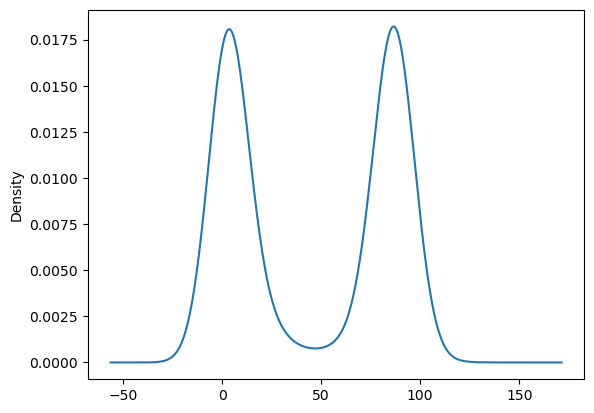

In [226]:
df[df['GPS_speed'] > 0]['GPS_speed'].plot(kind='kde')
print('Max overall trucks speed is: ' + str(max(df.GPS_speed)) + 'km/h')
print('Average truck traffic speed is', round(df[(df.GPS_speed > 0) & (df.GPS_speed < 50)]['GPS_speed'].mean(),2), 'km/h')
print('Average truck highway speed is', round(df[df.GPS_speed > 50]['GPS_speed'].mean(),2), 'km/h')

In [3]:
detector = mpd.TrajectoryStopDetector(my_traj)

NameError: name 'mpd' is not defined